[ВВЕДЕНИЕ](#section0)

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.  Выбор должен быть сделан на основе  метрики  SMAPE.

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

План работы:

[Задача 1: предсказание уровня удовлетворенности сотрудника](#section1)

[1 Загрузка данных](#section2)

[2 Предобработка данных](#section3)

[3 Исследовательский анализ данных](#section4)

[4 Подготовка данных](#section5)

[5 Обучение моделей](#section6) 

[6 Вывод](#section7) 

[Задача 2: предсказание увольнения сотрудника из компании](#section8) 

[1 Загрузка данных](#section9) 

[2 Предобработка данных](#section10) 

[3 Исследовательский анализ данных](#section11) 

[4 Добавление нового входного признака](#section12) 

[5 Подготовка данных](#section13) 

[6 Обучение моделей](#section14) 

[7 Вывод](#section15) 

[Общий Вывод](#section17) 

<a id='section1'></a> 
##  Задача 1: предсказание уровня удовлетворенности сотрудника

Импортируем библиотеки.

In [1]:
!pip install phik -q

In [2]:
!pip install --user --upgrade scikit-learn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

from matplotlib import rcParams
from scipy import stats as st
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    LabelEncoder,
    PolynomialFeatures
)

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 

from sklearn.metrics import (
    roc_auc_score,
    make_scorer
)
    
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

<a id='section2'></a> 
###  Загрузка данных

Загружаем тренировочную выборку.

In [4]:
try:
    data_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv',sep = ',')
except:
    data_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv',sep = ',')

Загружаем входные признаки тестовой выборки.

In [5]:
try:
    data_features = pd.read_csv('/datasets/test_features.csv',sep = ',')
except:
    data_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv',sep = ',')

Загружаем признак тестовой выборки.

In [6]:
try:
    data_test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv',sep = ',')
except:
    data_test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv',sep = ',')

Проверяем корректность загрузки.

In [7]:
display(data_train.head())
display(data_features.head())
display(data_test_target.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Данные загружены корректно.

<a id='section3'></a> 
###  Предобработка данных

Выведем общую информацию о датафрейме data_train и число полных дубликатов.

In [8]:
data_train.info()
display(f'Дубликатов {data_train.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


'Дубликатов 0'

In [9]:
data_train.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

В таблице 4000 строк, есть 6 пропусков в названии отдела и 3 пропуска в уровне должности, дубликатов нет.

Выведем общую информацию о датафрейме data_features и число полных дубликатов.

In [10]:
data_features.info()
display(f'Дубликатов {data_features.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


'Дубликатов 0'

В таблице 2000 строк, 2 пропуска в названии отдела и 1 пропуск в уровне должности, дубликатов нет.

Выведем общую информацию о датафрейме data_test_target и число полных дубликатов.

In [11]:
data_test_target.info()
display(f'Дубликатов {data_test_target.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


'Дубликатов 0'

В этой таблице 2000 строк, пропусков и дубликатов нет.

Создадим пайплайн для заполнения пропусков: если в данных есть пропуски, заполним их самым часто встречающимся значением.  

In [12]:
imputer_pipe =  Pipeline ([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
   ]
)

Применим его к датафреймам  data_train и data_features

In [13]:
data1=imputer_pipe.fit_transform(data_train)
data_train=pd.DataFrame(data1,columns=data_train.columns)

In [14]:
display(data_train.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.2


In [15]:
data2=pd.merge(data_features,data_test_target,how='inner',on='id')
data3=imputer_pipe.transform(data2)

data_features=pd.DataFrame(data3,columns=data2.columns)

data_features=data_features.drop('job_satisfaction_rate',axis=1)
display(data_features.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [16]:
display(data_features.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Выведем еще раз информацию об обоих датафреймах.

In [17]:
#возвращаем типы переменных, которые изменились при объединении в датафрейм на предыдущем шаге
data_train = data_train.convert_dtypes() 
data_features = data_features.convert_dtypes()

In [18]:
data_train.info()
data_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   Int64  
 1   dept                   4000 non-null   string 
 2   level                  4000 non-null   string 
 3   workload               4000 non-null   string 
 4   employment_years       4000 non-null   Int64  
 5   last_year_promo        4000 non-null   string 
 6   last_year_violations   4000 non-null   string 
 7   supervisor_evaluation  4000 non-null   Int64  
 8   salary                 4000 non-null   Int64  
 9   job_satisfaction_rate  4000 non-null   Float64
dtypes: Float64(1), Int64(4), string(5)
memory usage: 332.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  -----

Как видим, пропусков в данных больше нет.

<a id='section4'></a> 
###  Исследовательский анализ данных

#### Гистограммы для численных признаков.

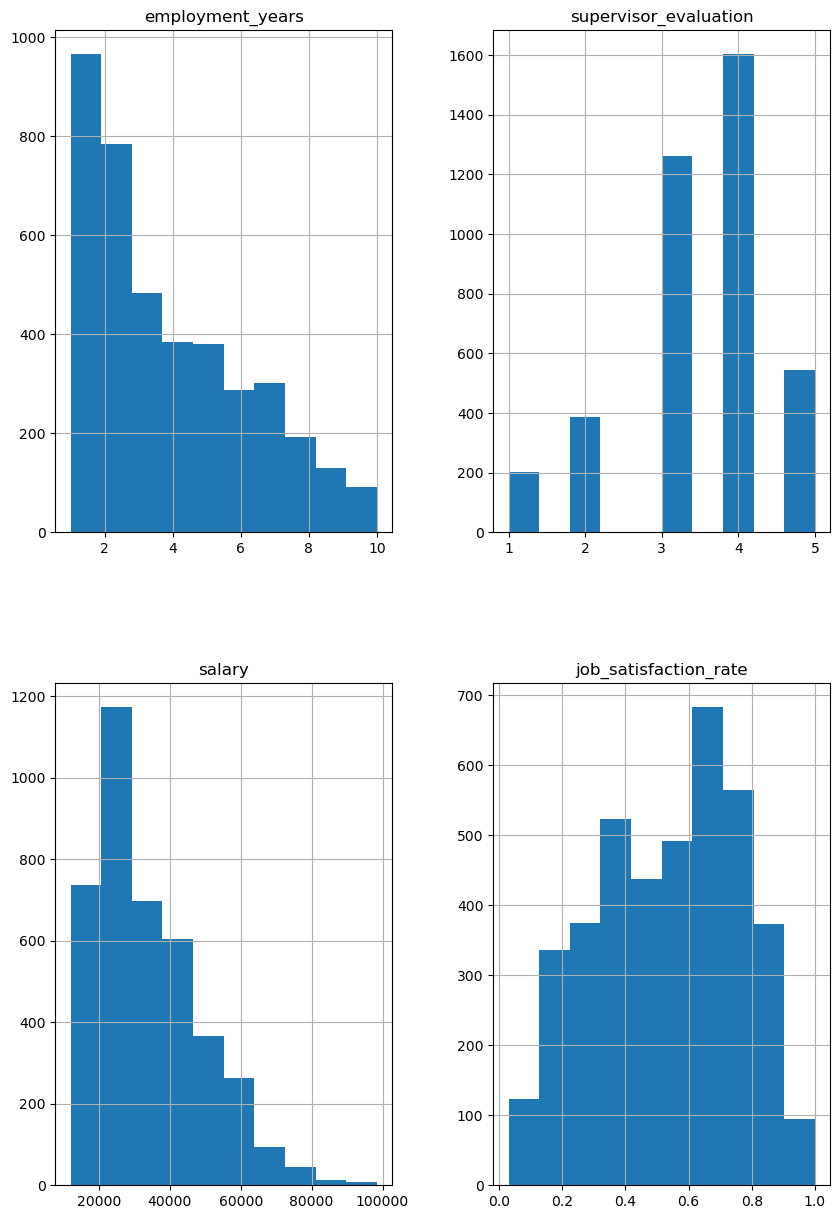

In [19]:
data_train.drop('id',axis=1).hist(figsize=(10, 15));

Построим гистограмму для зарплаты. 

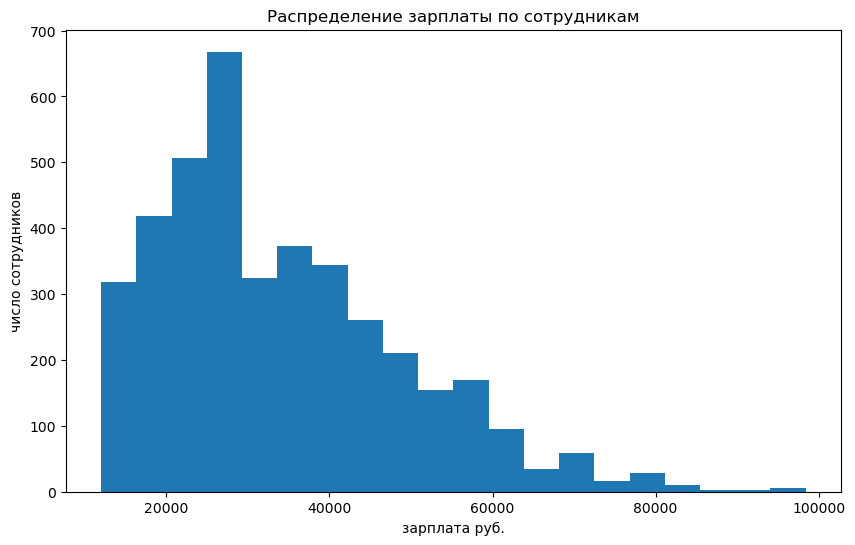

In [20]:
data_train['salary'].plot(kind='hist',bins=20,figsize=(10,6))
plt.title('Распределение зарплаты по сотрудникам') 
plt.xlabel('зарплата руб.') 
plt.ylabel('число сотрудников') 
plt.show()

Построим категориальную гистограмму для оценки работы руководителем.

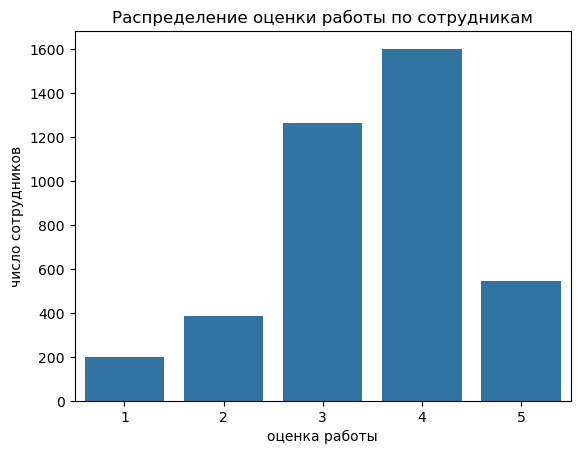

In [21]:
sns.countplot(data=data_train, x='supervisor_evaluation')

plt.title('Распределение оценки работы по сотрудникам') 
plt.xlabel('оценка работы') 
plt.ylabel('число сотрудников')
plt.show() 

Построим категориальную гистограмму для длительности работы в компании.

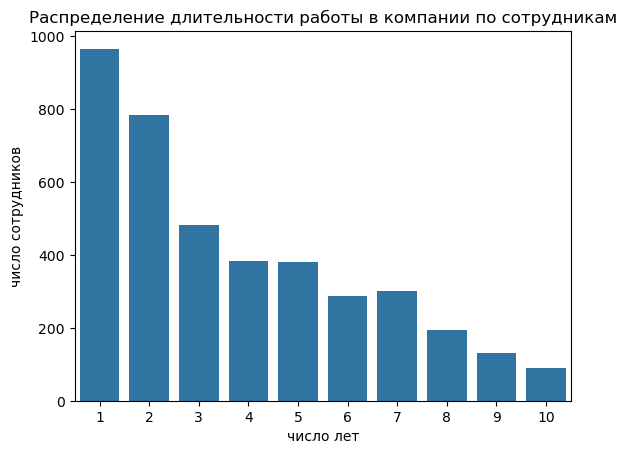

In [22]:
sns.countplot(data=data_train, x='employment_years')

plt.title('Распределение длительности работы в компании по сотрудникам') 
plt.xlabel('число лет') 
plt.ylabel('число сотрудников') 
plt.show() 

Построим гистограмму для целевого признака: уровня удовлетворенности работой. 

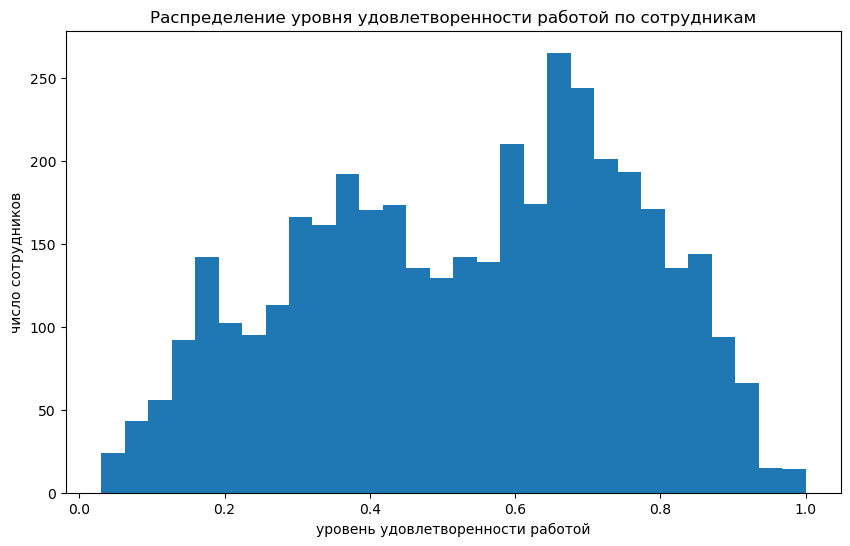

In [23]:
data_train['job_satisfaction_rate'].plot(kind='hist',bins=30,figsize=(10,6))
plt.title('Распределение уровня удовлетворенности работой по сотрудникам') 
plt.xlabel('уровень удовлетворенности работой') 
plt.ylabel('число сотрудников') 
plt.show()

Все данные выглядят правдоподобно, явных выбросов нет.

#### Столбчатые диаграммы для категориальных признаков .

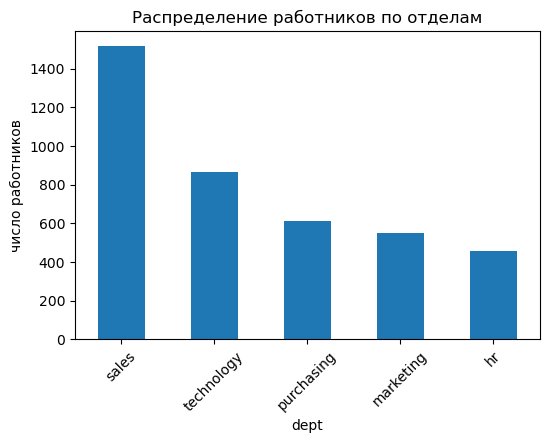

In [24]:
# Строим столбчатую диаграмму для отделов
freqs = data_train['dept'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Распределение работников по отделам') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

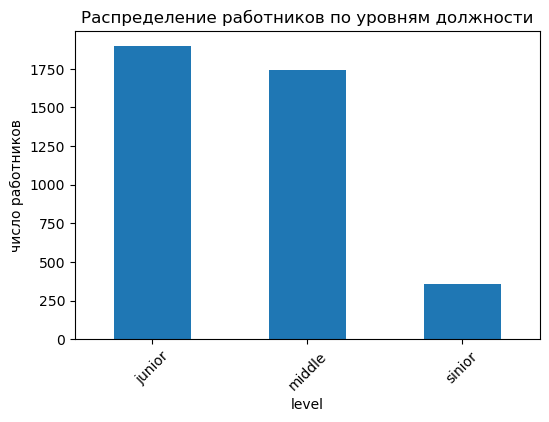

In [25]:
# Строим столбчатую диаграмму для уровней должности
freqs = data_train['level'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Распределение работников по уровням должности') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

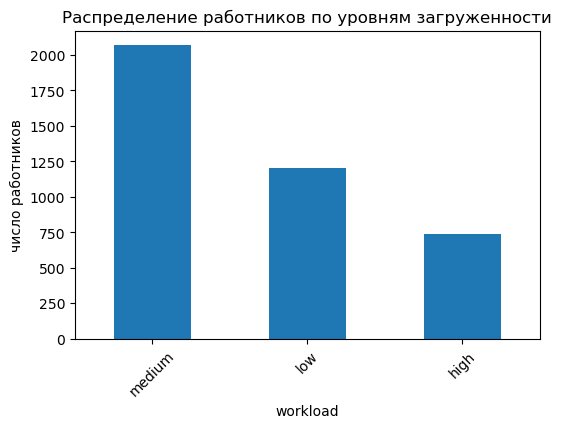

In [26]:
# Строим столбчатую диаграмму для уровней загруженности
freqs = data_train['workload'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Распределение работников по уровням загруженности') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

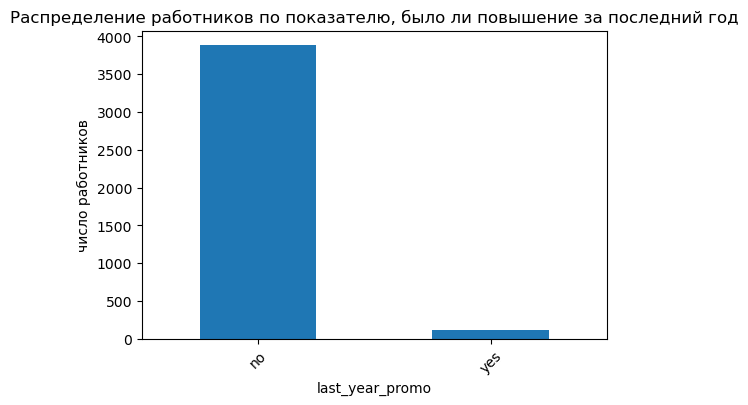

In [27]:
# Строим столбчатую диаграмму для показателя, было ли повышение за последний год
freqs = data_train['last_year_promo'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Распределение работников по показателю, было ли повышение за последний год') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

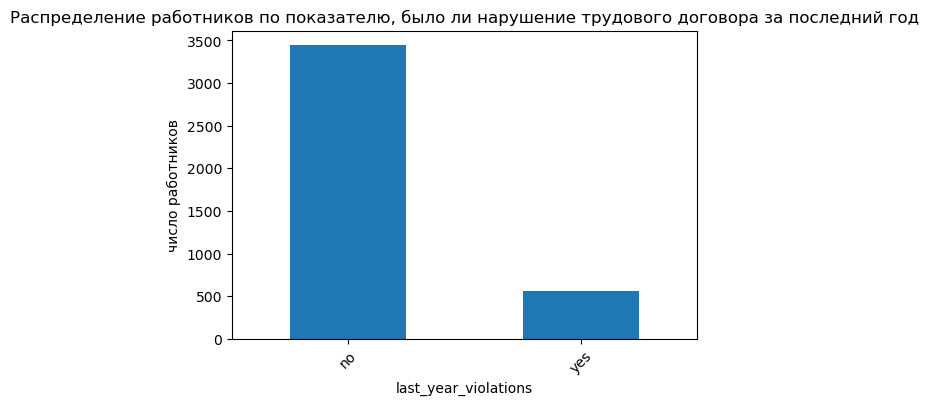

In [28]:
# Строим столбчатую диаграмму для показателя, было ли нарушение трудового договора за последний год
freqs = data_train['last_year_violations'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Распределение работников по показателю, было ли нарушение трудового договора за последний год') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

Вывод по исследовательскому анализу:
    
- основная масса сотрудников имеет невысокую зарплату - до 40000,
- большинство работает недолго в компании - 1-2 года,
- самая распространенная оценка работы - 4 и 3, худшую оценку имеет меньшинство сотрудников,
- по отделам больше всего работает в продажах, меньше всего в маркетинге и hr,
- по уровням должности больше всего младших и средних позиций, высших совсем немного,
- по загруженности большинство работников имеют среднюю загруженность, затем низкую, меньше всего - высокую,
- повышений в должности почти не было,
- нарушителей трудового договора  почти в 7 раз меньше, чем дисциплинированных работников.    
    
Целевой признак, уровень удовлетворенности работой,  представлен всеми значениями от 0 до 1, но в целом значений выше 0.5 больше, то есть довольных своей работой больше, чем недовольных.

#### Корреляционный анализ

Теперь рассчитаем коэффициенты корреляции Фи между всеми признаками (числовыми и категориальными) средствами библиотеки phik. 

In [29]:
data_1=data_train.drop('id',axis=1)
data_1.phik_matrix(interval_cols=['salary','job_satisfaction_rate']).style.background_gradient(cmap="RdYlGn")

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016542,0.036815,0.000000,0.000000,0.105706,0.282657,0.082659
level,0.000000,1.000000,0.419591,0.682962,0.101668,0.000000,0.000000,0.717761,0.080753
workload,0.016542,0.419591,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.036815,0.682962,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101668,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105706,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282657,0.717761,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082659,0.080753,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


У целевого признака уровня удовлетворенности работой (job_satisfaction_rate) высокая корреляция по шкале Чеддока наблюдается с оценкой качества работы (supervisor_evaluation) (0.73).

Заметный уровень корреляции с показателем нарушения трудового договора (last_year_violations) (0.59).

Умеренная корреляция с длительностью работы (employment_years) и показателем повышений за прошлый год (last_year_promo) ( 0.33 и 0.43 соответственно).

Слабая корреляция с зарплатой (salary), отделом (dept), уровнем должности (level) и уровнем загруженности (workload) (0.22,0.14, 0.18 и 0.12 соответственно).

Мультиколлинеарность наблюдается между зарплатой и загруженностью, коэффициент кореляции Фи равен 0.79.

#### Исследовательский анализ для test выборки

Построим столбчатые диаграммы для категориальных признаков тестовой выборки на одном графике для экономии места.

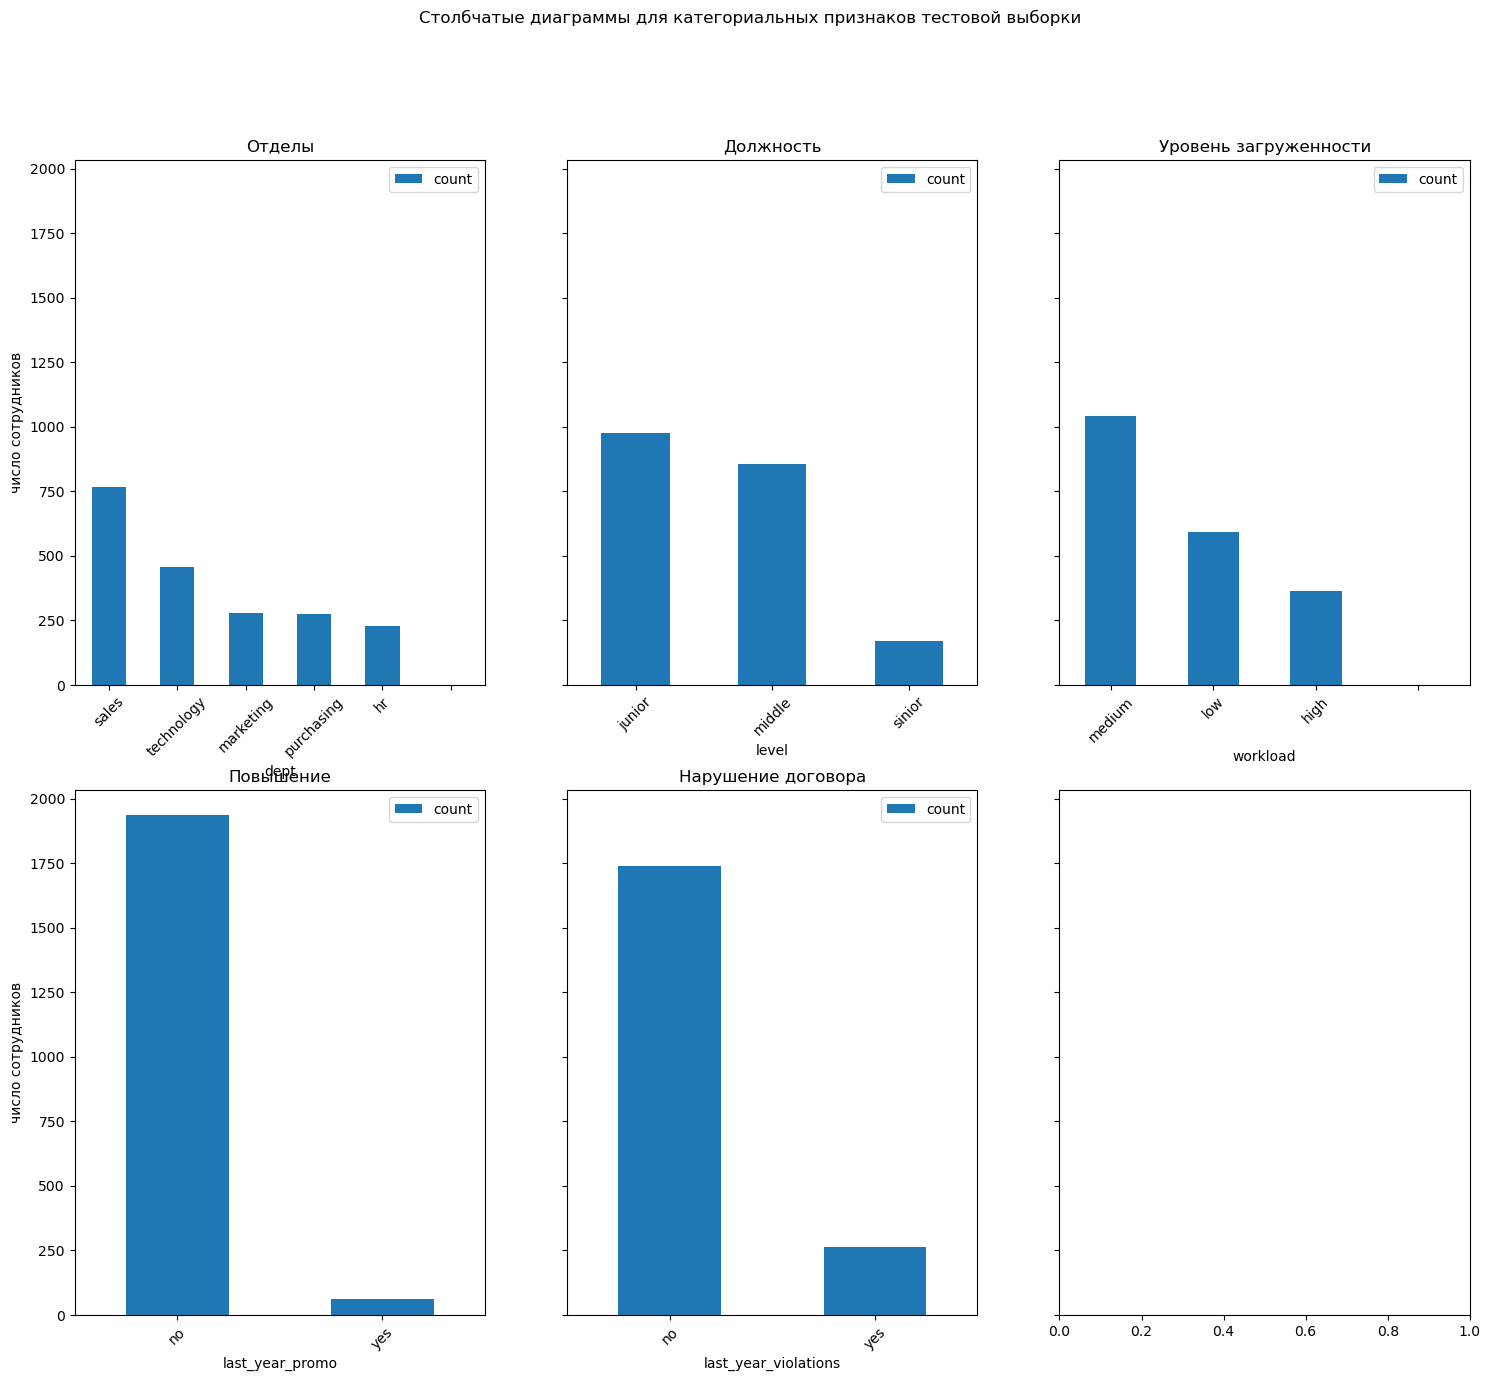

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(18, 15), sharey=True)

data1=data_features['dept'].value_counts()
data2=data_features['level'].value_counts()
data3= data_features['workload'].value_counts()
data4=data_features['last_year_promo'].value_counts()
data5=data_features['last_year_violations'].value_counts()

data1.plot.bar(ax=axs[0, 0],rot=45)
data2.plot.bar(ax=axs[0, 1],rot=45)
data3.plot.bar(ax=axs[0, 2],rot=45)
data4.plot.bar(ax=axs[1, 0],rot=45)
data5.plot.bar(ax=axs[1, 1],rot=45)

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()

axs[0,0].set_ylabel('число сотрудников')
axs[0,1].set_ylabel('число сотрудников')
axs[0,2].set_ylabel('число сотрудников')
axs[1,0].set_ylabel('число сотрудников')
axs[1,1].set_ylabel('число сотрудников')

axs[0,0].set_title('Отделы')
axs[0,1].set_title('Должность')
axs[0,2].set_title('Уровень загруженности')
axs[1,0].set_title('Повышение')
axs[1,1].set_title('Нарушение договора')

fig.suptitle('Столбчатые диаграммы для категориальных признаков тестовой выборки')
plt.show()

По графикам видно, что эти признаки распределены примерно так же, как и в тренировочной, только в отделах и уровне загруженности появился пустой столбец.

Посмотрим, какие значения принимают эти столбцы.

In [31]:
data_features['dept'].unique()

<StringArray>
['marketing', 'hr', 'sales', 'purchasing', 'technology', ' ']
Length: 6, dtype: string

In [32]:
data_features['workload'].unique()

<StringArray>
['medium', 'low', 'high', ' ']
Length: 4, dtype: string

В значения отделов и уровня загруженности попали пробелы, оценим количество строк с пробелами.

In [33]:
print(len(data_features[(data_features['dept']==' ') | (data_features['workload']==' ')]  )    )

2


Как видим, 2 строки с пробелами в тестовых данных.

Это немного, но для корректной подготовки данных нужно учесть этот факт и использовать параметр handle_unknown при масштабировании и кодировании, чтобы модель знала, что делать с неизвестными значениями, которых не было в тренировочной выборке, на которой она обучалась. 

Теперь построим категориальные гистограммы для тестовой выборки.

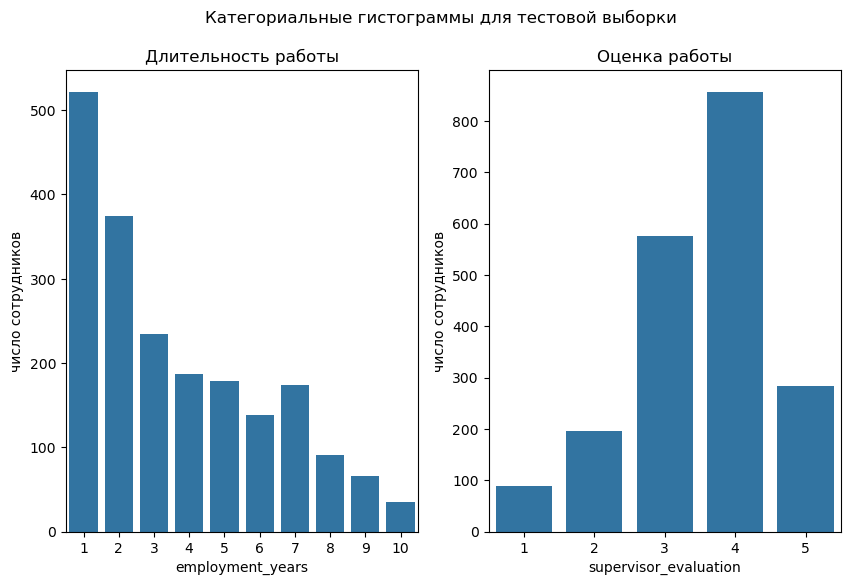

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

fig.suptitle('Категориальные гистограммы для тестовой выборки')

sns.countplot(ax=axes[0], data=data_features, x='employment_years')
sns.countplot(ax=axes[1], data=data_features, x='supervisor_evaluation')

axes[0].set_title('Длительность работы')
axes[1].set_title('Оценка работы')

axes[0].set_ylabel('число сотрудников')
axes[1].set_ylabel('число сотрудников')

plt.show()

Для зарплаты и уровня удовлетворенности работой (численных признаков) построим гистограммы.

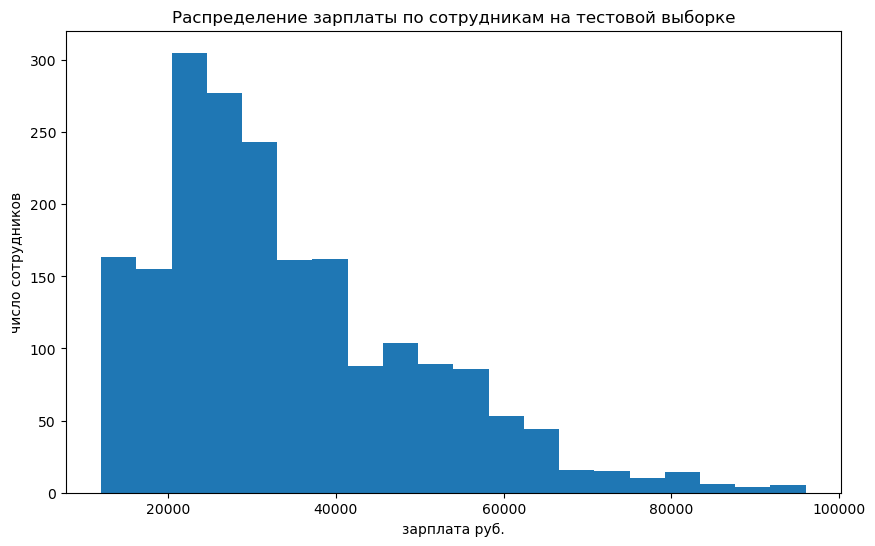

In [35]:
data_features['salary'].plot(kind='hist',bins=20,figsize=(10,6))
plt.title('Распределение зарплаты по сотрудникам на тестовой выборке') 
plt.xlabel('зарплата руб.') 
plt.ylabel('число сотрудников') 
plt.show()

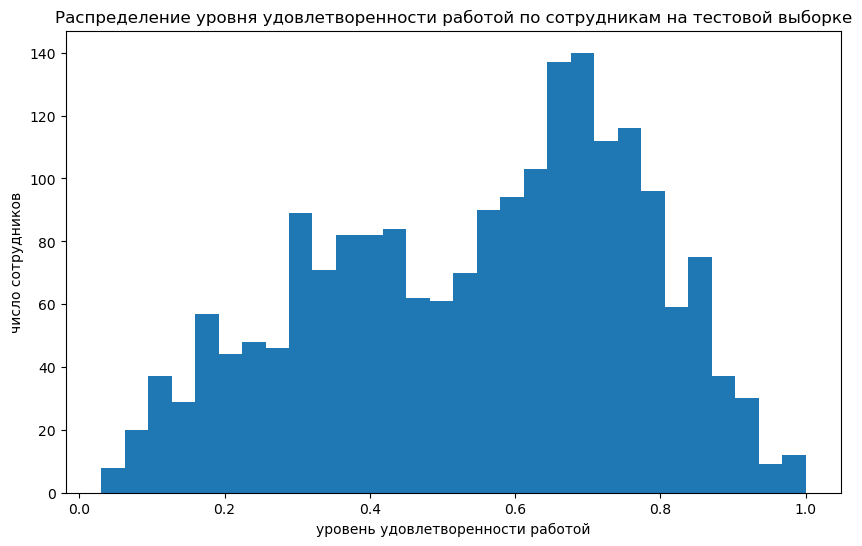

In [36]:
data_test_target['job_satisfaction_rate'].plot(kind='hist',bins=30,figsize=(10,6))
plt.title('Распределение уровня удовлетворенности работой по сотрудникам на тестовой выборке') 
plt.xlabel('уровень удовлетворенности работой') 
plt.ylabel('число сотрудников') 
plt.show()

Проведем еще корреляционный анализ для тестовой выборки средствами библиотеки phik.

In [37]:
data_test=pd.merge(data_features,data_test_target,how='inner',on='id')
data_1=data_test.drop('id',axis=1)

data_1.phik_matrix(interval_cols=['salary','job_satisfaction_rate']).style.background_gradient(cmap="RdYlGn")

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.031183,0.000000,0.000000,0.000000,0.017512,0.237864,0.031274
level,0.000000,1.000000,0.196785,0.689747,0.118283,0.017551,0.000000,0.749068,0.097007
workload,0.031183,0.196785,1.000000,0.167397,0.082891,0.000000,0.008174,0.739462,0.000000
employment_years,0.000000,0.689747,0.167397,1.000000,0.173637,0.066371,0.000000,0.494701,0.313525
last_year_promo,0.000000,0.118283,0.082891,0.173637,1.000000,0.000000,0.011704,0.193727,0.337002
last_year_violations,0.000000,0.017551,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.554811
supervisor_evaluation,0.017512,0.000000,0.008174,0.000000,0.011704,0.189719,1.000000,0.114588,0.769857
salary,0.237864,0.749068,0.739462,0.494701,0.193727,0.000000,0.114588,1.000000,0.171903
job_satisfaction_rate,0.031274,0.097007,0.000000,0.313525,0.337002,0.554811,0.769857,0.171903,1.000000


У целевого признака уровня удовлетворенности работой 

высокая корреляция с оценкой качества работы 0.77 (на тренировочной 0.73),

заметный уровень корреляции с показателем нарушения трудового договора 0.55 (на тренировочной 0.59),

умеренная корреляция с длительностью работы  и показателем повышений за прошлый год 0.31 и 0.34 (на тренировочной 0.33 и 0.43 соответственно),

слабая корреляция с зарплатой, отделом, уровнем должности и уровнем загруженности, как и на тренировочной выборке.

Коэффициент кореляции Фи  между зарплатой и загруженностью равен 0.74 (на тренировочной 0.79).

Итого, данные в тестовой выборке распределены примерно так же, как в тренировочной, только в названиях отделов и уровня загруженности встречаются пробелы, это надо учесть при подготовке данных.

<a id='section5'></a> 
### Подготовка данных

#### Кодирование и масштабирование

Для решения задачи мы будем использовать две модели: линейную регрессию и дерево решений для регрессии.

Формируем тренировочную выборку из data_train.

Удалим id из таблицы и проверим ее после этого на дубликаты.

In [38]:
X_train_0= data_train.drop(
        ['id'], 
        axis=1
    )

In [39]:
X_train_0.duplicated().sum()

248

Удалим  дубликаты.

In [40]:
X_train_0 = X_train_0.drop_duplicates()
X_train_0.duplicated().sum()

0

Теперь формируем тренировочную выборку, удаляя целевой признак из таблицы.

In [41]:
X_train=X_train_0.drop(
        ['job_satisfaction_rate'], 
        axis=1
    )

In [42]:
y_train=X_train_0['job_satisfaction_rate']

Для получения тестовой выборки сначала объединим data_features с data_test_target по id, чтобы привести в соответствие работников и их уровни удовлетворенности. Затем выделяем из объединенного датафрейма X_test и y_test.

In [43]:
data_test=pd.merge(data_features,data_test_target,how='inner',on='id')

In [44]:
X_test=data_test.drop(
 ['job_satisfaction_rate','id'], 
         axis=1)
y_test=data_test['job_satisfaction_rate']

Выделяем категориальные и количественные признаки.

In [45]:
#категориальные признаки
ohe_columns = [
    'dept', 'last_year_promo','last_year_violations'
]

#категориальные порядковые признаки
ord_columns = [
    'level','workload'
]

#количественные признаки
num_columns = [
    'employment_years', 'salary','supervisor_evaluation'
 ]

Создаём пайплайн для подготовки признаков из списка ohe_columns с помощью OHE-кодирования (категории, которые есть в test, но нет в train, будем игнорировать).

In [46]:
RANDOM_STATE=42

In [47]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder( drop='first',handle_unknown='ignore', sparse_output=False)
        )
    ]
)

Добавляем пайплайн для Ordinal-кодирования. Неизвестные категории, которые встретятся в тестовой выборке, будут заменены на пропуски.

In [48]:
ord_pipe = Pipeline(
    [
         (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ), 
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle','sinior'], 
                    ['low','medium','high']
                   
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Для численных категорий возьмем StandardScaler() для масштабирования.

Создаём общий пайплайн для подготовки данных категориальных и количественных переменных.

In [49]:
data_preprocessor = ColumnTransformer(
   transformers = [
      ('ohe', ohe_pipe, ohe_columns),
      ('ord', ord_pipe, ord_columns),
      ('num', StandardScaler(), num_columns)
   ],
    remainder='passthrough')

<a id='section6'></a> 
###  Обучение моделей

In [50]:
def smape_metric(y_true, y_pred):
    metric = 100*2* np.mean(abs(y_true-y_pred)/(abs(y_true)+abs(y_pred)))
    return metric 

In [51]:
# создаём пользовательскую метрику
score = make_scorer(smape_metric,greater_is_better=False) 

Поиск наилучшей модели для задачи прогнозирования уровня удовлетворенности работой. 

Список словарей,  каждый словарь — это модель с гиперпараметрами, методами подготовки данных и числом отбираемых наилучших признаков.

In [52]:
param_distributions = [
    # словарь для модели LinearRegression
    {
        # название модели
        'models': [LinearRegression()],
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'select__k':range(1, 12),
 
    },
    # словарь для модели DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 100),
        'models__min_samples_leaf': range(1, 10),
        'models__min_samples_split': range(2, 10),
        'models__max_depth': range(2, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'select__k':range(1, 12),

    }   
   
] 

Итоговый пайплайн, включает в себя подготовку данных,  отбор наилучших признаков и модель.

In [53]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('select', SelectKBest(f_classif)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Наилучшая модель ищется методом случайного поиска, метрика пользовательская, кроссвалидация проводится на 5 выборках.

In [54]:
randomized_search_all = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring=score, 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=1000,
    cv=5
)
randomized_search_all.fit(X_train, y_train) 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                        {'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 100),
                                         'models__min_samples_leaf': range(1, 10),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough'],
                                         'select__k': range(1, 12)}],
                   random_state=42,
                   scoring=make_scorer(smape_metric, greater_is_better=False, response_method='predict'))

In [55]:
print('Лучшая модель и её параметры:\n\n', randomized_search_all.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [56]:
print('Гиперпараметры',randomized_search_all.best_params_)

Гиперпараметры {'select__k': 11, 'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 7, 'models__min_samples_leaf': 1, 'models__max_depth': 97, 'models': DecisionTreeRegressor(random_state=42)}


Наилучшая модель - дерево регрессии  с гиперпараметрами:
    
глубина дерева 97,
    
миним. число объектов для разделения узла 7,
    
миним. число число объектов в листе 1,
    
масштабирование с помощью MinMaxScaler(),    

отобрано 11 наилучших признаков.  

In [57]:
best_model = randomized_search_all.best_estimator_

In [58]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search_all.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 


,rank_test_score,param_models,mean_test_score,params
233,1,DecisionTreeRegressor(random_state=42),-15.102941,"{'select__k': 11, 'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 7, 'models__min_samples_leaf': 1, 'models__max_depth': 97, 'models': DecisionTreeRegressor(random_state=42)}"
942,2,DecisionTreeRegressor(random_state=42),-15.107495,"{'select__k': 11, 'preprocessor__num': 'passthrough', 'models__min_samples_split': 8, 'models__min_samples_leaf': 2, 'models__max_depth': 28, 'models': DecisionTreeRegressor(random_state=42)}"
507,3,DecisionTreeRegressor(random_state=42),-15.112811,"{'select__k': 11, 'preprocessor__num': StandardScaler(), 'models__min_samples_split': 8, 'models__min_samples_leaf': 2, 'models__max_depth': 54, 'models': DecisionTreeRegressor(random_state=42)}"
207,4,DecisionTreeRegressor(random_state=42),-15.126374,"{'select__k': 11, 'preprocessor__num': 'passthrough', 'models__min_samples_split': 7, 'models__min_samples_leaf': 1, 'models__max_depth': 42, 'models': DecisionTreeRegressor(random_state=42)}"
41,5,DecisionTreeRegressor(random_state=42),-15.161346,"{'select__k': 11, 'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 1, 'models__max_depth': 82, 'models': DecisionTreeRegressor(random_state=42)}"
...,...,...,...,...
344,912,DecisionTreeRegressor(random_state=42),-25.677543,"{'select__k': 1, 'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 5, 'models__max_depth': 49, 'models': DecisionTreeRegressor(random_state=42)}"
574,912,DecisionTreeRegressor(random_state=42),-25.677543,"{'select__k': 1, 'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 9, 'models__min_samples_leaf': 1, 'models__max_depth': 9, 'models': DecisionTreeRegressor(random_state=42)}"
355,912,DecisionTreeRegressor(random_state=42),-25.677543,"{'select__k': 1, 'preprocessor__num': StandardScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 8, 'models__max_depth': 78, 'models': DecisionTreeRegressor(random_state=42)}"
300,912,DecisionTreeRegressor(random_state=42),-25.677543,"{'select__k': 1, 'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 6, 'models__max_depth': 8, 'models': DecisionTreeRegressor(random_state=42)}"


Теперь для лучшей модели рассчитаем метрику smape. 

In [59]:
y_pred=best_model.predict(X_test)
print(f'Метрика smape на тестовой выборке: {smape_metric(y_test, y_pred)}') 

Метрика smape на тестовой выборке: 13.759072671500764


C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Значение метрики на тестовой выборке соответствует критерию успеха.

Проверка модели на адекватность. 
    
Чтобы узнать, не предвзята ли наша модель, сравним её с такой, которая всегда присваивает объектам мажорный класс. 
    
В качестве константной модели будем использовать класс DummyClassifier.

In [60]:
# создание и обучение модели DummyClassifier 
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# оценка качества модели по метрике smape
smape_metric(y_test, dummy_model_preds)

37.54518593053283

Метрика smape модели DummyClassifier на тестовой выборке явно хуже, чем нашей лучшей.
    
Поэтому можно считать нашу модель адекватной.

<a id='section7'></a> 
###   Вывод

Методом случайного поиска определена наилучшая модель для прогнозирования уровня удовлетворенности работой, осуществлен подбор гиперпараметров,  и отобраны наилучшие признаки.
    
Найденная модель соответствует критерию успеха по метрике smape, сравнение с константной моделью показало ее адекватность.

<a id='section8'></a> 
##  Задача 2: предсказание увольнения сотрудника из компании

<a id='section9'></a> 
###  Загрузка данных

Загружаем тренировочную выборку.

In [61]:
try:
    data_train_quit = pd.read_csv('/datasets/train_quit.csv',sep = ',')
except:
    data_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv',sep = ',')

Входные признаки тестовой выборки те же, что в задаче 1.

In [62]:
 data_features_quit= data_features

Загружаем целевой признак тестовой выборки.

In [63]:
try:
    data_test_target_quit = pd.read_csv('/datasets/test_target_quit.csv',sep = ',')
except:
    data_test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv',sep = ',')

In [64]:
display(data_train_quit.head())
display(data_test_target_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные загружены корректно.

<a id='section10'></a> 
###   Предобработка данных

Выведем общую информацию о датафрейме data_train_quit и число полных дубликатов.

In [65]:
data_train_quit.info()
display(f'Дубликатов {data_train_quit.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


'Дубликатов 0'

Выведем общую информацию о целевом признаке data_test_target_quit и число полных дубликатов.

In [66]:
data_test_target_quit.info()
display(f'Дубликатов { data_test_target_quit.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


'Дубликатов 0'

В данных нет пропусков и полных дубликатов.

In [67]:
data_test=pd.merge(data_features,data_test_target_quit,how='inner',on='id')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   Int64 
 1   dept                   2000 non-null   string
 2   level                  2000 non-null   string
 3   workload               2000 non-null   string
 4   employment_years       2000 non-null   Int64 
 5   last_year_promo        2000 non-null   string
 6   last_year_violations   2000 non-null   string
 7   supervisor_evaluation  2000 non-null   Int64 
 8   salary                 2000 non-null   Int64 
 9   quit                   2000 non-null   object
dtypes: Int64(4), object(1), string(5)
memory usage: 164.2+ KB


<a id='section11'></a> 
###  Исследовательский анализ данных

#### Численные столбцы датафрейма data_train_quit.

Построим гистограмму для зарплаты . 

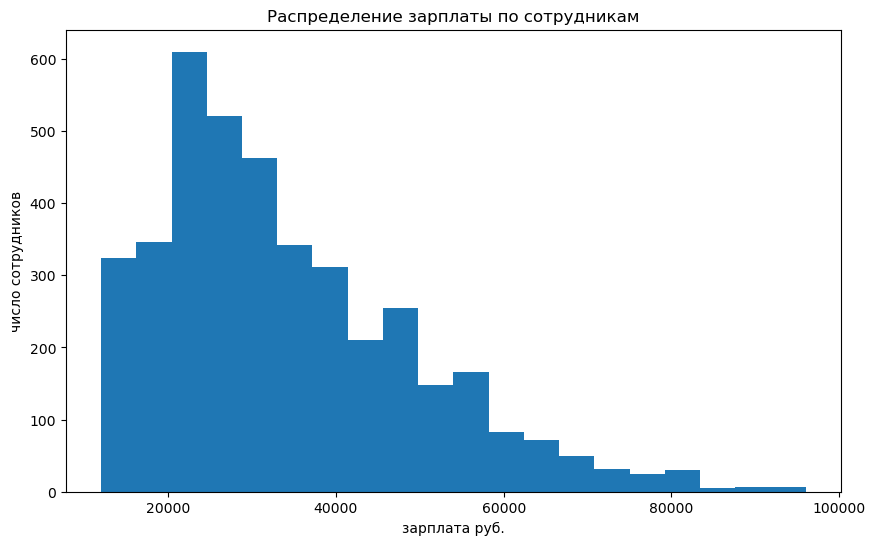

In [68]:
data_train_quit['salary'].plot(kind='hist',bins=20,figsize=(10,6))
plt.title('Распределение зарплаты по сотрудникам') 
plt.xlabel('зарплата руб.') 
plt.ylabel('число сотрудников') 
plt.show()

Построим категориальную гистограмму для оценки работы руководителем.

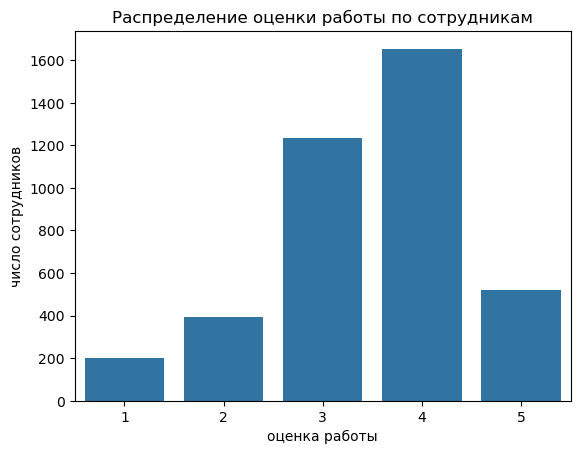

In [69]:
sns.countplot(data=data_train_quit, x='supervisor_evaluation')

plt.title('Распределение оценки работы по сотрудникам') 
plt.xlabel('оценка работы') 
plt.ylabel('число сотрудников')
plt.show() 

Построим категориальную гистограмму для длительности работы в компании.

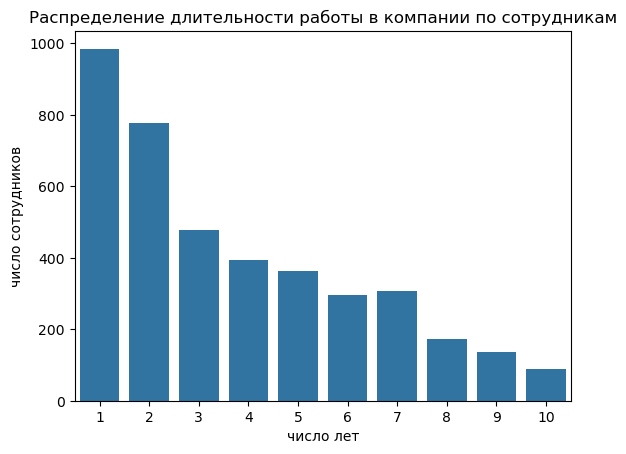

In [70]:
sns.countplot(data=data_train_quit, x='employment_years')

plt.title('Распределение длительности работы в компании по сотрудникам') 
plt.xlabel('число лет') 
plt.ylabel('число сотрудников') 
plt.show() 

Явных выбросов в данных не наблюдается. На нормальное распределение не похоже ни одно из трех.

#### Категориальные признаки. 

Построим для них столбчатые диаграммы.

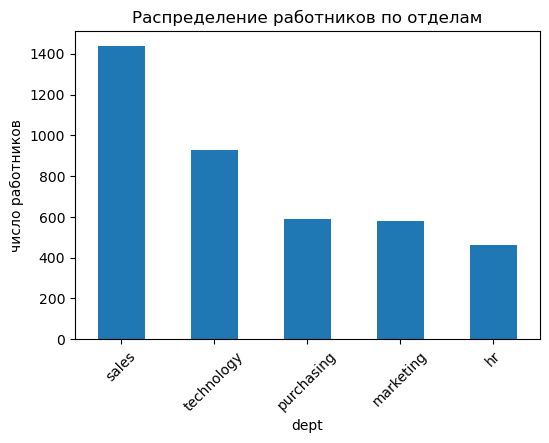

In [71]:
#Строим столбчатую диаграмму для отделов
freqs = data_train_quit['dept'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Распределение работников по отделам') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

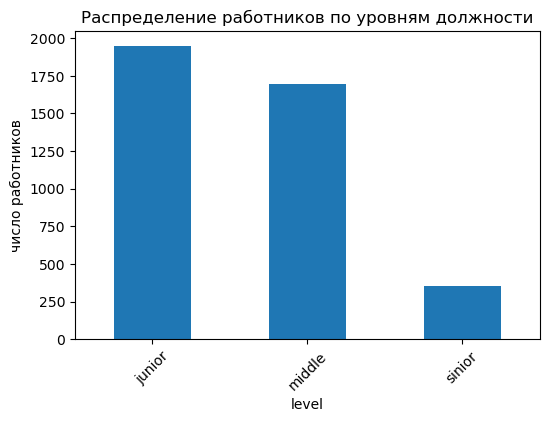

In [72]:
# Строим столбчатую диаграмму для уровней должности
freqs = data_train_quit['level'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Распределение работников по уровням должности') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

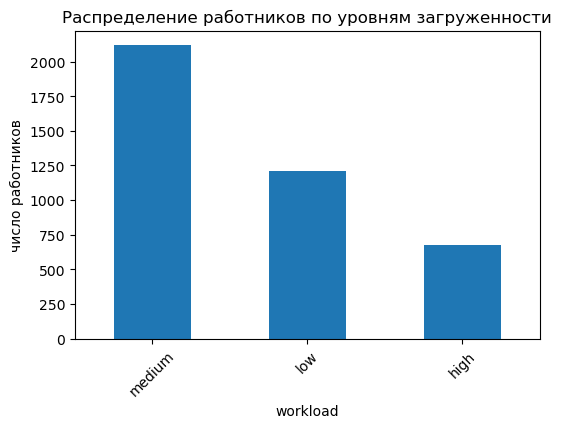

In [73]:
# Строим столбчатую диаграмму для уровней загруженности
freqs = data_train_quit['workload'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Распределение работников по уровням загруженности') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

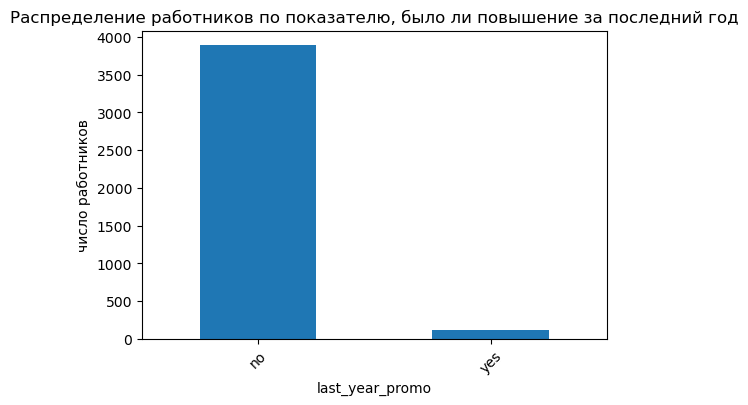

In [74]:
# Строим столбчатую диаграмму для показателя, было ли повышение за последний год
freqs = data_train_quit['last_year_promo'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Распределение работников по показателю, было ли повышение за последний год') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

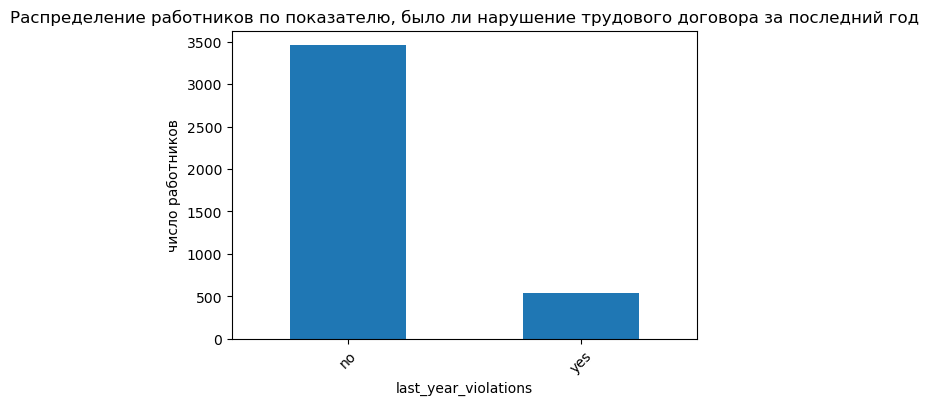

In [75]:
# Строим столбчатую диаграмму для показателя, было ли нарушение трудового договора за последний год
freqs = data_train_quit['last_year_violations'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('Распределение работников по показателю, было ли нарушение трудового договора за последний год') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

Распределение целевого признака -увольнения:

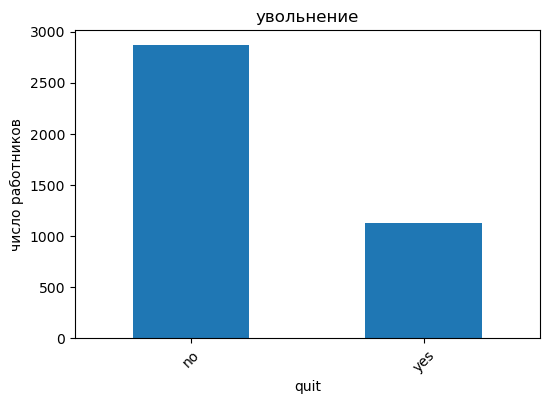

In [76]:
# Строим столбчатую диаграмму для целевого признака
freqs = data_train_quit['quit'].value_counts()

ax = freqs.plot.bar(figsize=(6,4))

plt.title('увольнение') 
plt.ylabel('число работников')
plt.xticks(rotation=45)
plt.show()

Корреляционный анализ для тренировочной выборки.

In [77]:
data_1=data_train_quit.drop('id',axis=1)

data_1.phik_matrix(interval_cols=['salary']).style.background_gradient(cmap="RdYlGn")

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000


Вывод по исследовательскому анализу:
    
- основная масса сотрудников имеет невысокую зарплату - до 40000,
- большинство работает недолго в компании - 1-2 года,
- самая распространенная оценка работы - 4 и 3, худшую оценку имеет меньшинство сотрудников,
- по отделам больше всего работает в продажах, меньше всего в маркетинге и hr,
- по уровням должности больше всего младших и средних позиций, высших совсем немного,
- по загруженности большинство работников имеют среднюю загруженность, затем низкую, меньше всего - высокую,
- повышений в должности почти не было,
- нарушителей трудового договора  почти в 7 раз меньше, чем дисциплинированных работников.    
    
По целевому признаку- увольнению - выявлено, что оставшихся сотрудников примерно в 2.5 раза боьше, чем уволившихся.
    
Корреляционный анализ показал, что целевой признак заметно корреллирует с длительностью работы и зарплатой, умеренно коррелирует с уровнем должности и слабо коррелирует с остальными признаками (коэффициенты корреляции Фи).

#### Портрет уволившегося сотрудника.

Для целевого признака изменим обозначения: пусть  1- уволившийся, 0 - неуволившийся сотрудник

In [78]:
# создаем экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()
label_encoder.fit(data_train_quit['quit'])# обучаем модель

y_train = label_encoder.transform(data_train_quit['quit'])# трансформируем тренировочную выборку
y_test = label_encoder.transform(data_test_target_quit['quit'])# трансформируем тестовую выборку

data_train_quit['quit']=y_train#заменяем столбец в data_train_quit
data_test_target_quit['quit']=y_test#заменяем столбец в data_test_target_quit

In [79]:
pd.DataFrame(y_train, data_train_quit['quit'], columns=['LabelEncoder'])

,LabelEncoder
quit,
0,0
0,0
0,0
1,1
0,0
...,...
0,0
0,0
1,1


In [80]:
print(label_encoder.classes_)

['no' 'yes']


In [81]:
pred_classes = [0, 1]
print(label_encoder.inverse_transform(pred_classes)) 

['no' 'yes']


Посмотрим, какая доля сотрудников уволилась в каждом отделе.

In [82]:
display(data_train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,0
1,814010,sales,junior,medium,2,no,no,4,27600,0
2,155091,purchasing,middle,medium,5,no,no,1,37200,0
3,257132,sales,junior,medium,2,no,yes,3,24000,1
4,910140,marketing,junior,medium,2,no,no,5,25200,0


In [83]:
df = data_train_quit.pivot_table(index='dept', values='quit',aggfunc={'quit':['count','sum']})
display(df)

,count,sum
dept,,
hr,464,116
marketing,582,163
purchasing,588,166
sales,1438,407
technology,928,276


,dept,count,sum,gone,left
0,hr,464,116,0.250000,0.750000
1,marketing,582,163,0.280069,0.719931
2,purchasing,588,166,0.282313,0.717687
3,sales,1438,407,0.283032,0.716968
4,technology,928,276,0.297414,0.702586


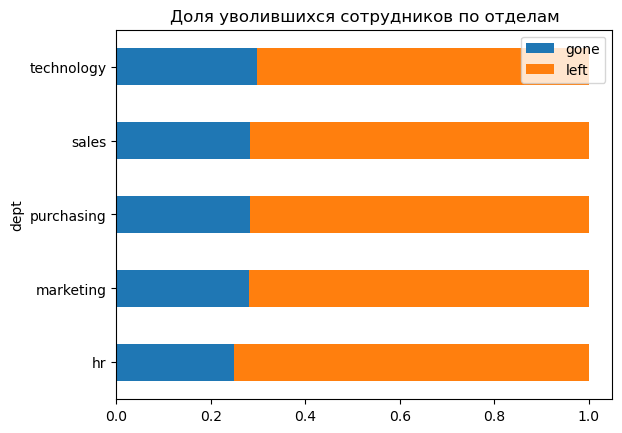

In [84]:
#сводная таблица по отделам, выводим число уволившихся и всех сотрудников в отделе
df = data_train_quit.pivot_table(index='dept', values='quit',aggfunc={'quit':['count', 'sum']}).reset_index()

#считаем доли уволившихся и оставшихся
df['gone']=df['sum'] /df['count']
df['left']=1-df['gone']
display(df)

#убираем ненужные столбцы и строим сложенную столбчатую диаграмму
df=df.drop(['count','sum'],axis=1)
df.set_index('dept')
df.plot.barh(x='dept',stacked=True, title='Доля уволившихся сотрудников по отделам',legend=True) 
plt.show() 

Сильной разницы по отделам незаметно, из hr уволилось меньше всего.

Посмотрим, в каких должностях уволилось больше всего сотрудников. 

,level,count,sum,gone,left
0,junior,1949,1003,0.514623,0.485377
1,middle,1694,108,0.063754,0.936246
2,sinior,357,17,0.047619,0.952381


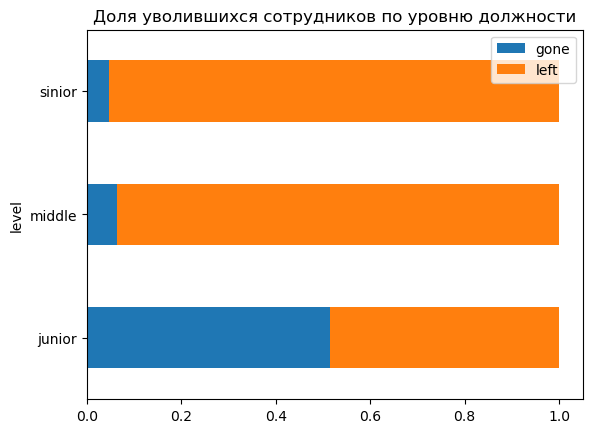

In [85]:
#сводная таблица по уровню должности
df =  data_train_quit.pivot_table(index='level', values='quit',aggfunc={'quit':['count', 'sum']}).reset_index()

#считаем доли уволившихся и оставшихся
df['gone']=df['sum'] /df['count']
df['left']=1-df['gone']
display(df)

#убираем ненужные столбцы и строим сложенную столбчатую диаграмму
df=df.drop(['count','sum'],axis=1)
df.set_index('level')
df.plot.barh(x='level',stacked=True, title='Доля уволившихся сотрудников по уровню должности',legend=True) 
plt.show()


 В младших должностях уволилось половина сотрудников, в отличие от средних и топовых позиций.

Теперь исследуем, сколько уволилось в каждой категории загруженности. 

,workload,count,sum,gone,left
0,high,674,121,0.179525,0.820475
1,low,1208,519,0.429636,0.570364
2,medium,2118,488,0.230406,0.769594


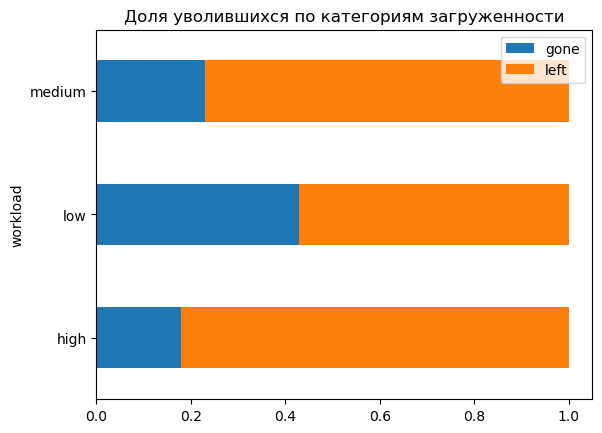

In [86]:
#строим сложенную столбчатую диаграмму по категориям загруженности
df =  data_train_quit.pivot_table(index='workload', values='quit',aggfunc={'quit':['count', 'sum']}).reset_index()

df['gone']=df['sum'] /df['count']
df['left']=1-df['gone']
display(df)

df=df.drop(['count','sum'],axis=1)
df.set_index('workload')
df.plot.barh(x='workload',stacked=True, title='Доля уволившихся по категориям загруженности',legend=True) 
plt.show()


Больше всего уволилось в наименее загруженной категории работников.

Теперь посмотрим на распределение зарплаты у уволившихся и оставшихся сотрудников.

In [87]:
#создаем два датафрейма для построения гистограмм для уволившихся и оставшихся сотрудников
data_gone=data_train_quit[data_train_quit['quit']==1]
data_left=data_train_quit[data_train_quit['quit']==0]

Построим нормированные гистограммы для зарплаты уволившихся и оставшихся отрудников.

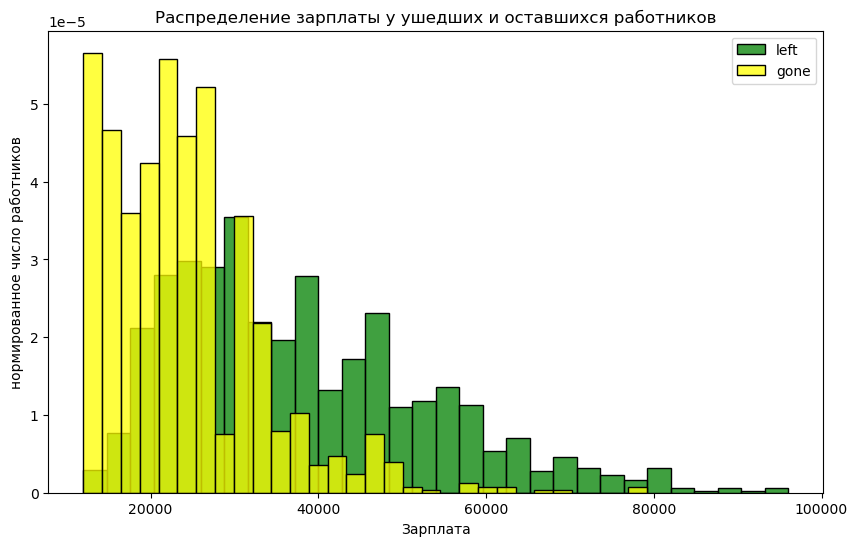

In [88]:
fig = plt.subplots(figsize=(10,6))
sns.histplot(data_left['salary'],stat='density', common_norm=False,color='green',label='left',bins=30)
sns.histplot(data_gone['salary'],stat='density', common_norm=False,color='yellow',label='gone',bins=30)

plt.title('Распределение зарплаты у ушедших и оставшихся работников') 
plt.xlabel('Зарплата') 
plt.ylabel('нормированное число работников')  

plt.legend()
plt.show()

Гистограммы накладываются в районе наименьших значений, посторим еще диаграммы размаха для зарплаты уволившихся и оставшихся сотрудников.

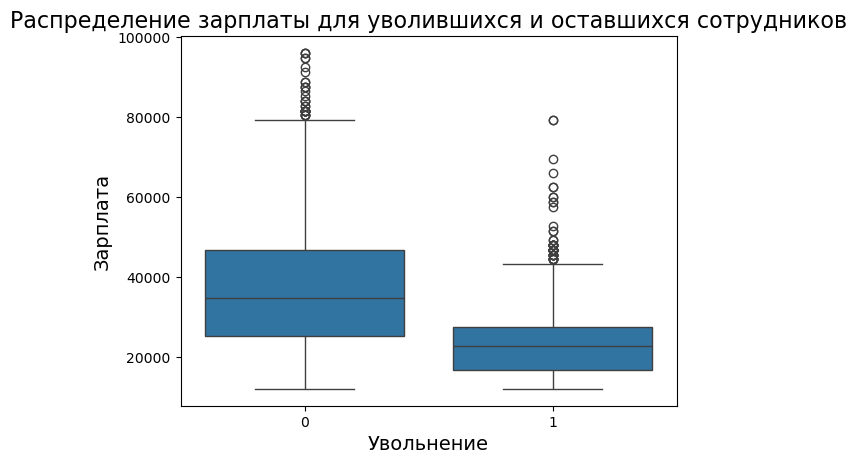

In [89]:
#диаграммы размаха для зарплаты для уволившихся и оставшихся сотрудников
boxplot = sns.boxplot(y=data_train_quit['salary'],x=data_train_quit['quit']);
boxplot.axes.set_title('Распределение зарплаты для уволившихся и оставшихся сотрудников', fontsize=16)
boxplot.set_xlabel('Увольнение', fontsize=14)
boxplot.set_ylabel('Зарплата', fontsize=14);

Выведем и сравним все статистические характеристики зарплаты для ушедших и оставшихся сотрудников.

In [90]:
display(data_left['salary'].describe())
display(data_gone['salary'].describe())

count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

У ушедших сотрудников среднее по зарплате было 23885 рублей, у оставшихся 37702,
    
медиана по зарплате у ушедших была 22800, у оставшихся 34800.

Таким образом, зарплата у уволившихся была сильно ниже, чем у оставшихся.

Посмотрим, сколько лет отработали в компании уволившиеся и оставшиеся сотрудники.

Построим нормированные гистограммы для длительности работы в компании для уволившихся и оставшихся отрудников

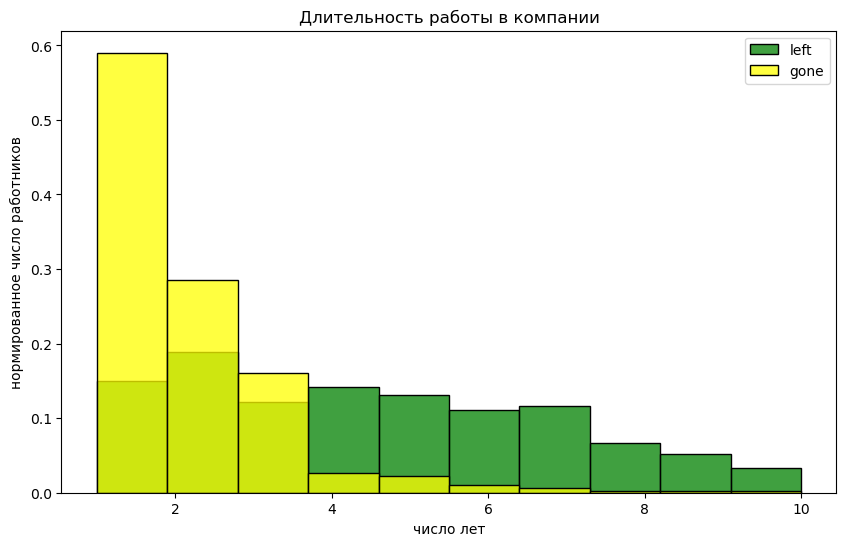

In [91]:
#строим гистограммы для длительности работы в компании для уволившихся и оставшихся отрудников
fig = plt.subplots(figsize=(10,6))

sns.histplot(data_left['employment_years'],stat='density', common_norm=False,color='green',label='left',bins=10)
sns.histplot(data_gone['employment_years'],stat='density', common_norm=False,color='yellow',label='gone',bins=10)

#data_left['employment_years'].hist(bins=20,figsize=(10,6),label='left')
#data_gone['employment_years'].hist(bins=20,figsize=(10,6),label='gone')

plt.title('Длительность работы в компании') 
plt.xlabel('число лет') 
plt.ylabel('нормированное число работников')  

plt.legend()
plt.show()

Те, кто уволился, проработали в компании недолго: в основном 1-3 лет. 

Теперь исследуем оценку качества работы уволившихся и оставшихся сотрудников.

,supervisor_evaluation,count,sum,gone,left
0,1,202,95,0.470297,0.529703
1,2,391,164,0.419437,0.580563
2,3,1233,523,0.424169,0.575831
3,4,1654,286,0.172914,0.827086
4,5,520,60,0.115385,0.884615


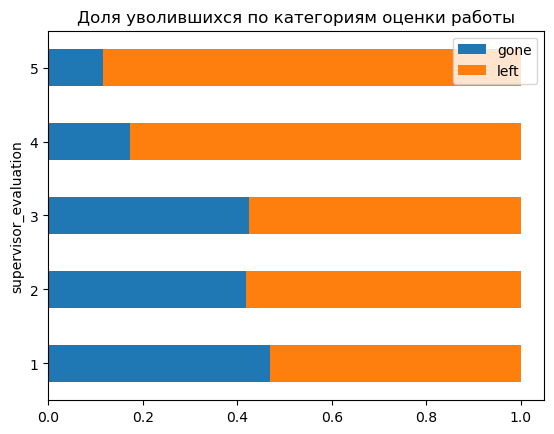

In [92]:
#строим сложенную столбчатую диаграмму по оценке качества работы
df =  data_train_quit.pivot_table(index='supervisor_evaluation', values='quit',aggfunc={'quit':['count', 'sum']}).reset_index()

df['gone']=df['sum'] /df['count']
df['left']=1-df['gone']
display(df)

df=df.drop(['count','sum'],axis=1)
df.set_index('supervisor_evaluation')
df.plot.barh(x='supervisor_evaluation',stacked=True, title='Доля уволившихся по категориям оценки работы',legend=True)
plt.show()

Больше всего уволившихся имели плохую оценку качества работы.

Посмотрим, кого из двух категорий больше повышали за последний год.

,last_year_promo,count,sum,gone,left
0,no,3887,1127,0.289941,0.710059
1,yes,113,1,0.008850,0.991150


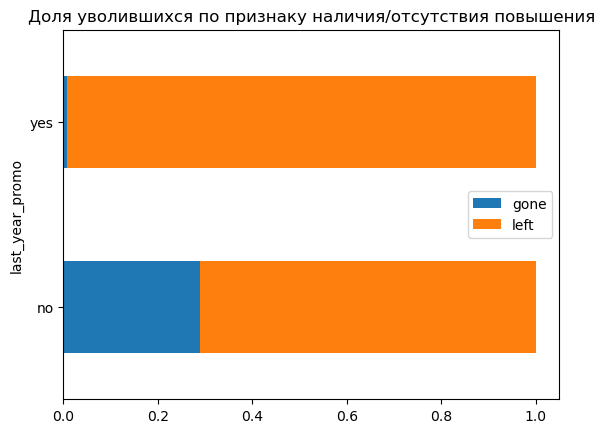

In [93]:
#строим сложенную столбчатую диаграмму по наличию/отсутствию повышения
df =  data_train_quit.pivot_table(index='last_year_promo', values='quit',aggfunc={'quit':['count', 'sum']}).reset_index()

df['gone']=df['sum'] /df['count']
df['left']=1-df['gone']
display(df)

df=df.drop(['count','sum'],axis=1)
df.set_index('last_year_promo')
df.plot.barh(x='last_year_promo',stacked=True, title='Доля уволившихся по признаку наличия/отсутствия повышения',legend=True) 
plt.show()

Среди тех, кого повышали в должности, уволившихся практически нет, в отличие от тех, кого не повышали.

Последними рассмотрим тех, кто чаще нарушал трудовой договор.

,last_year_violations,count,sum,gone,left
0,no,3455,900,0.260492,0.739508
1,yes,545,228,0.418349,0.581651


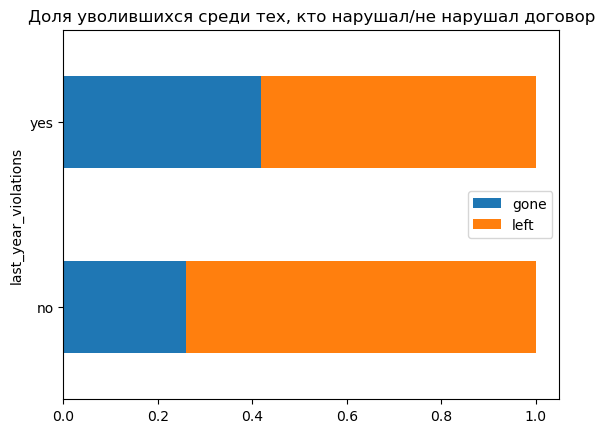

In [94]:
#строим сложенную столбчатую диаграмму по нарушению/ не нарушению трудового договора
df =  data_train_quit.pivot_table(index='last_year_violations', values='quit',aggfunc={'quit':['count', 'sum']}).reset_index()

df['gone']=df['sum'] /df['count']
df['left']=1-df['gone']
display(df)
#display(df.columns)
df=df.drop(['count','sum'],axis=1)
df.set_index('last_year_violations')
df.plot.barh(x='last_year_violations',stacked=True, title='Доля уволившихся среди тех, кто нарушал/не нарушал договор',legend=True)
plt.show()

В категории нарушителей уволившихся больше, чем среди тех, кто не нарушал.

Таким образом,типичный уволившийся сотрудник - это недолго проработавший в компании работник, на низкой должности и с маленькой зарплатой, мало загруженный, с низкой оценкой качества работы, чаще нарушающий трудовой договор и не повышавшийся в должности. То есть либо молодой, либо безответственный или безынициативный работник на нисших должностях.

Проверим утверждение о  том, что уровень удовлетворенности сотрудника работой влияет на его увольнение.

Построим нормированные гистограммы для распределения работников по уровню удовлетворенности работой.

Для этого объединим тестовые выборки data_test_target из 1-ой задачи и data_test_target_quit из 2-ой по id.

In [95]:
df=pd.merge(data_test_target,data_test_target_quit,on='id',how='inner')

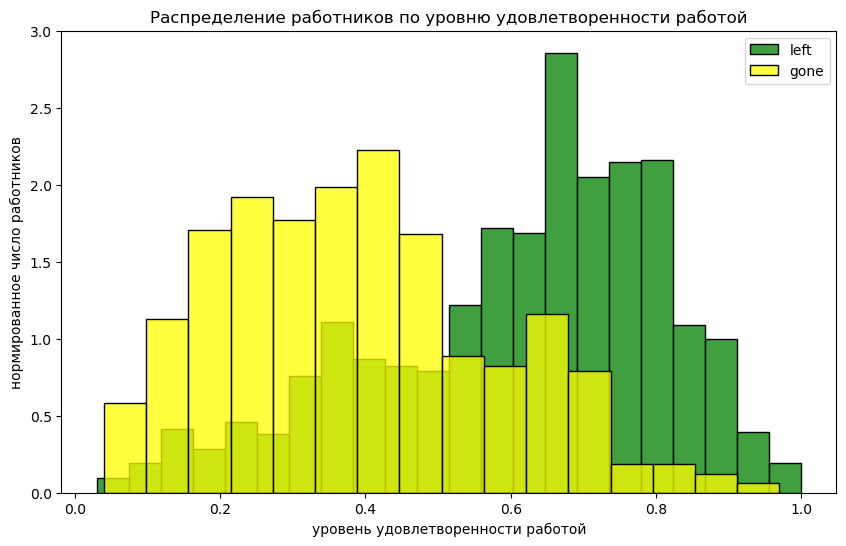

In [96]:
#строим гистограммы для распределения работников по уровню удовлетворенности работой
#отдельно для уволившихся и оставшихся сотрудников
fig = plt.subplots(figsize=(10,6))

sns.histplot(df[df['quit']==0]['job_satisfaction_rate'],stat='density', common_norm=False,color='green',label='left')
sns.histplot(df[df['quit']==1]['job_satisfaction_rate'],stat='density', common_norm=False,color='yellow',label='gone')

plt.title('Распределение работников по уровню удовлетворенности работой') 
plt.xlabel('уровень удовлетворенности работой') 
plt.ylabel('нормированное число работников')  

plt.legend()
plt.show()

Как видим, у уволившихся сотрудников практически нет высоких показателей удовлетворенностью работой, в отличие от оставшихся. Поэтому можно сказать, что уровень удовлетворенности работой и увольнение взаимосвязаны.

Проверим гипотезу о равенстве средних двух генеральных совокупностей: зарплаты ушедших и оставшихся сотрудников, в предположении, что эти выборки независимы, выборочные средние нормально распределены и дисперсии рассматриваемых генеральных совокупностей равны.
    
Нулевая гипотеза: средние значения зарплаты ушедших и оставшихся сотрудников равны,
    
Альтернативная — средние значения ушедших и оставшихся сотрудников не равны.
    
Уровень статистической значимости установим 0.05.
    
Используем метод scipy.stats.ttest_ind. для проверки гипотезы о равенстве среднего двух генеральных совокупностей.

In [97]:
alpha =0.05 #уровень стат. значимости

results =st.ttest_ind(df[df['quit']==0]['job_satisfaction_rate'],df[df['quit']==1]['job_satisfaction_rate']) 

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.2311220665171928e-104
Отвергаем нулевую гипотезу


Таким образом, отвергаем нулевую гипотезу в пользу альтернативной: средние зарплаты ушедших и оставшихся сотрудников не равны.

<a id='section12'></a> 
###  Добавление нового входного признака

Добавляем в тренировочные (data_train_quit) и тестовые данные (data_features_quit) 2 задачи признак удовлетворенности работой, полученный с помощью прогноза лучшей модели из [п.1.5.2.2](#section16).

In [98]:
data_train_quit['job_satisfaction_rate']=best_model.predict(data_train_quit.drop(
        ['id','quit'], 
        axis=1
    ))

Входные признаки тестовой выборки те же, что в задаче 1, там для тестовой выборки мы уже получали предсказанные значения y_pred, их и записываем в столбец job_satisfaction_rate тестовой выборки задачи 2.

In [99]:
data_features_quit['job_satisfaction_rate']=y_pred

<a id='section13'></a> 
###  Подготовка данных

Выделяем тренировочную выборку.

Удалим id из таблицы и проверим ее после этого на дубликаты.

In [100]:
X_train_0= data_train_quit.drop(
        ['id'], 
        axis=1
    )
X_train_0.duplicated().sum()

1413

Удалим дубликаты.

In [101]:
X_train_0 = X_train_0.drop_duplicates()
X_train_0.duplicated().sum()

0

Формируем тренировочную выборку без дубликатов.

In [102]:
X_train=X_train_0.drop(
        ['quit'], 
        axis=1
    )

#y_train=data_train_quit['quit']
y_train=X_train_0['quit']

In [103]:
display(data_train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,0,0.600000
1,814010,sales,junior,medium,2,no,no,4,27600,0,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,0,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,1,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,0,0.690000


Выделяем тестовую выборку, для этого объединяем data_features и data_test_target_quit по id, чтобы привести в соответсвие входные признаки и целевой.

In [104]:
data_test_quit=pd.merge(data_features, data_test_target_quit,how='inner',on='id')

In [105]:
 display(data_test_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.885000,0
1,686555,hr,junior,medium,1,no,no,4,30000,0.681429,0
2,467458,sales,middle,low,5,no,no,4,19200,0.654000,0
3,418655,sales,middle,low,6,no,no,4,19200,0.655000,0
4,789145,hr,middle,medium,5,no,no,5,40800,0.812500,0


Выделяем тестовую выборку.

In [106]:
X_test=data_test_quit.drop(
 ['quit','id'], 
         axis=1)
y_test=data_test_quit['quit']

К количественным признакам добавляется job_satisfaction_rate.

In [107]:
#категориальные признаки
ohe_columns = [
    'dept', 'last_year_promo','last_year_violations'
]

#категориальные порядковые признаки
ord_columns = [
    'level','workload'
]

#количественные признаки
num_columns = [
    'employment_years', 'salary','supervisor_evaluation','job_satisfaction_rate'
 ]

Пайплайн для кодирования.

In [108]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder( drop='first',handle_unknown='ignore', sparse_output=False)
        )
    ]
)

Пайплайн для кодирования категориальных порядковых признаков.

In [109]:
ord_pipe = Pipeline(
    [
         (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ), 
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle','sinior'], 
                    ['low','medium','high']
                   
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Итоговый пайплайн для преобразования данных (для масштабирования используем StandardScaler()).

In [110]:
data_preprocessor = ColumnTransformer(
   transformers = [
      ('ohe', ohe_pipe, ohe_columns),
      ('ord', ord_pipe, ord_columns),
      ('num', StandardScaler(), num_columns)
   ],
    remainder='passthrough')

<a id='section14'></a> 
###  Обучение моделей

Итоговый пайплайн для поиска наилучшей модели, включает в себя добавление полиномиальных признаков и отбор наилучших признаков.

In [111]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('poly', PolynomialFeatures()),
    ('select', SelectKBest(f_classif)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Список словарей,  каждый словарь — это модель с гиперпараметрами, методами подготовки данных, степенью полиномиальных признаков и числом отбираемых наилучших признаков.

In [112]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 20),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'select__k':range(1, 12),
        'poly__degree':range(2, 4)
    },
     # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'select__k':range(1, 12),
        'poly__degree':range(2, 4)
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,penalty='l1')],
        'models__C': [0.5,1,2,3,4,5,6,7,8,9,10],
        'models__solver': ['liblinear', 'saga'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'select__k':range(1, 12),
        'poly__degree':range(2, 4)
    }
   
] 

Поиск наилучшей модели.

In [113]:
randomized_search_all = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=1000
)
randomized_search_all.fit(X_train, y_train) 

C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 0 14 15 16 26 27 37] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough'],
                                         'select__k': range(1, 12)},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42)],
                                         'models__C': [0.5, 1, 2, 3, 4, 5, 6, 7,
                                                       8, 9, 10],
                                         'models__solver': ['liblinear',
                                                            'saga'],
                                         'poly__degree': range(2, 4),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough'],
                                         'select__k': range(1, 12)}],
                   random_state=42, scoring='roc_auc')

In [114]:
print('Лучшая модель и её параметры:\n\n', randomized_search_all.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [115]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search_all.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 


,rank_test_score,param_models,mean_test_score,params
645,1,KNeighborsClassifier(),0.910643,"{'select__k': 9, 'preprocessor__num': StandardScaler(), 'poly__degree': 2, 'models__n_neighbors': 16, 'models': KNeighborsClassifier()}"
38,2,KNeighborsClassifier(),0.910327,"{'select__k': 11, 'preprocessor__num': StandardScaler(), 'poly__degree': 2, 'models__n_neighbors': 18, 'models': KNeighborsClassifier()}"
826,3,KNeighborsClassifier(),0.909078,"{'select__k': 10, 'preprocessor__num': StandardScaler(), 'poly__degree': 2, 'models__n_neighbors': 15, 'models': KNeighborsClassifier()}"
499,4,"LogisticRegression(penalty='l1', random_state=42)",0.908225,"{'select__k': 10, 'preprocessor__num': StandardScaler(), 'poly__degree': 2, 'models__solver': 'liblinear', 'models__C': 8, 'models': LogisticRegression(penalty='l1', random_state=42)}"
623,5,"LogisticRegression(penalty='l1', random_state=42)",0.908221,"{'select__k': 10, 'preprocessor__num': StandardScaler(), 'poly__degree': 2, 'models__solver': 'saga', 'models__C': 7, 'models': LogisticRegression(penalty='l1', random_state=42)}"
...,...,...,...,...
312,996,KNeighborsClassifier(),0.728536,"{'select__k': 7, 'preprocessor__num': MinMaxScaler(), 'poly__degree': 2, 'models__n_neighbors': 1, 'models': KNeighborsClassifier()}"
199,997,KNeighborsClassifier(),0.715916,"{'select__k': 5, 'preprocessor__num': MinMaxScaler(), 'poly__degree': 3, 'models__n_neighbors': 1, 'models': KNeighborsClassifier()}"
97,998,KNeighborsClassifier(),0.697335,"{'select__k': 4, 'preprocessor__num': MinMaxScaler(), 'poly__degree': 2, 'models__n_neighbors': 1, 'models': KNeighborsClassifier()}"
238,999,KNeighborsClassifier(),0.644283,"{'select__k': 2, 'preprocessor__num': StandardScaler(), 'poly__degree': 3, 'models__n_neighbors': 1, 'models': KNeighborsClassifier()}"


Лучшей моделью оказалась модель k-соседей с гиперпараметром 16,
    
масштабированием StandardScaler(),
    
добавлены полиномиальные признаки степени 2 
    
и отобраны 9 наилучших признаков.

Метрика roc_auc наилучшей модели на тестовой выборке.

In [116]:
best_model = randomized_search_all.best_estimator_
y_pred=best_model.predict_proba(X_test)
roc_auc_score(y_test,y_pred[:,1])

C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9210776832809815

Найденная модель соответствует критерию успеха по метрике roc_auc.

Можно посмотреть список отобранных наилучших признаков.

Все признаки после подготовки preprocessor-ом.

In [117]:
columns_0=best_model.named_steps['preprocessor'].get_feature_names_out()
print(columns_0)

['ohe__dept_marketing' 'ohe__dept_purchasing' 'ohe__dept_sales'
 'ohe__dept_technology' 'ohe__last_year_promo_yes'
 'ohe__last_year_violations_yes' 'ord__level' 'ord__workload'
 'num__employment_years' 'num__salary' 'num__supervisor_evaluation'
 'num__job_satisfaction_rate']


Все признаки после добавления полиномиальных:

In [118]:
columns=best_model.named_steps['poly'].get_feature_names_out()
print(columns)

['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x0^2'
 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x0 x8' 'x0 x9'
 'x0 x10' 'x0 x11' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5' 'x1 x6' 'x1 x7'
 'x1 x8' 'x1 x9' 'x1 x10' 'x1 x11' 'x2^2' 'x2 x3' 'x2 x4' 'x2 x5' 'x2 x6'
 'x2 x7' 'x2 x8' 'x2 x9' 'x2 x10' 'x2 x11' 'x3^2' 'x3 x4' 'x3 x5' 'x3 x6'
 'x3 x7' 'x3 x8' 'x3 x9' 'x3 x10' 'x3 x11' 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7'
 'x4 x8' 'x4 x9' 'x4 x10' 'x4 x11' 'x5^2' 'x5 x6' 'x5 x7' 'x5 x8' 'x5 x9'
 'x5 x10' 'x5 x11' 'x6^2' 'x6 x7' 'x6 x8' 'x6 x9' 'x6 x10' 'x6 x11' 'x7^2'
 'x7 x8' 'x7 x9' 'x7 x10' 'x7 x11' 'x8^2' 'x8 x9' 'x8 x10' 'x8 x11' 'x9^2'
 'x9 x10' 'x9 x11' 'x10^2' 'x10 x11' 'x11^2']


Лушие признаки, отобранные  SelectKBest.

In [119]:
cols_idxs=best_model.named_steps['select'].get_support(indices = True)

In [120]:
print(*columns[cols_idxs], sep='\n')

x6
x8
x9
x11
x5 x8
x6^2
x6 x7
x7 x8
x7 x9


Видно, что  SelectKBest в лучшей модели отобрал 4 одномерных признака ('level', 'employment_years', 'salary', 'job_satisfaction_rate') 
    
и 5 признаков второй степени.

Проверка модели на адекватность. 
    
Чтобы узнать, не предвзята ли наша модель, сравним её с такой, которая всегда присваивает объектам мажорный класс. 
    
В качестве константной модели будем использовать класс DummyClassifier.

In [121]:
# создание и обучение модели DummyClassifier 
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# оценка качества модели по метрике smape
roc_auc_score(y_test, dummy_model_preds)

0.5

Метрика roc_auc модели DummyClassifier на тестовой выборке явно хуже, чем нашей лучшей.
    
Поэтому можно считать нашу модель адекватной.

<a id='section15'></a> 
###  Вывод

Таким образом, методом случайного поиска выбрана наилучшая модель для предсказания увольнения сотрудника,
    
осуществлен подбор гиперпараметров, добавлены полиномиальные признаки (степень полиномов подобрана как гиперпараметр) 
    
и отобраны наилучшие признаки после добавления полиномиальных.
    
Найденная модель соответствует критерию успеха по метрике roc_auc, сравнение с константной моделью показало ее адекватность.

<a id='section17'></a> 
## Общий вывод

Главной целью исследования было предсказание оттока сотрудников из компании  на основе данных заказчика.

В результате первого этапа работы была построена модель для предсказания уровня удовлетворённости сотрудника.

Работа включала в себя:

- предобработку данных, в результате которой были устранены пропуски в данных,
- исследовательский анализ, включая корреляционный, для визуализации входных и целевого признака и нахождения взаимосвязей между ними,
- подготовку данных (категорирование и масштабирование признаков),
- поиск наилучшей модели для прогнозирования уровня удовлетворенности работой, подбор гиперпараметров,  и отбор наилучших признаков.
    
Найденная модель соответствует критерию успеха по метрике smape, сравнение с константной моделью показало ее адекватность.

Второй этап работы имел целью построение модели, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Задача включала в себя:

- предобработку данных,
- исследовательский анализ,
- составление "портрета уволившегося сотрудника"
- добавление нового входного признака "уровень удовлетверенности работой", полученного из предсказаний лучшей модели, получнной на 1 этапе работы,
- подготовку данных (категорирование и масштабирование признаков),
- поиск наилучшей модели для предсказания увольнения сотрудника.

Анализ важности признаков выявил, что для всех моделей наибольшую важность имеют: уровень удовлетворенности работой, уровень должности, загруженность, зарплата, длительность работы и оценка руководителя. 

Соответственно, для предотвращения оттока сотрудников необходимо воздействовать на эти признаки, а именно:

увеличивать вовлеченность сотрудников путем поощрения в виде премий, наград, грамот и т.п.,

выявлять хороших работников и вовремя повышать их в должности и увеличивать им зарплату.